In [1]:
import os
import argparse
import torch
from networks.vnet import VNet
import SimpleITK as sitk
from tensorflow.keras.utils import to_categorical

In [2]:
import h5py
import math
import nibabel as nib
import numpy as np
from medpy import metric
import torch
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os



def predict_and_center_cut_all_case(net, image_list, num_classes, 
                        patch_size=(112, 112, 80), stride_xy=18, stride_z=4, 
                        save_result=True, test_save_path=None, preproc_fn=None,
                        device='cpu'):
    for image_path in tqdm(image_list):
        id = image_path.split('/')[-2]
        print(id,':')
        out_dir = test_save_path+id
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
            
        h5f = h5py.File(image_path, 'r')
        image = h5f['image'][:]
        if preproc_fn is not None:
            image = preproc_fn(image)
        label_pred, score_map = test_single_case(
            net, image, 
            stride_xy, stride_z, patch_size, 
            num_classes=num_classes, 
            device=device)
        
        import pdb
        pdb.set_trace()
        filter_mask = filter_connected_domain(label_pred,num_keep_region=None,ratio_keep=0.001)
        filter_mask = (filter_mask>0).astype(float)
        import pdb
        pdb.set_trace()
        label_pred = label_pred*filter_mask

        # 发现圆形视场的边界处经常出现错误分割(轮廓线),因此需要手动过滤
        r = label_pred.shape[0]/2
        xc,yc = label_pred.shape[0]/2,label_pred.shape[0]/2
#         filter_mask = np.ones(label_pred.shape)
#         for x in range(label_pred.shape[0]):
#             for y in range(label_pred.shape[1]):
#                 filter_mask[x,y,:] = 0 if r*0.5<np.sqrt((x-xc)**2+(y-yc)**2)<r*2 else 1
#         label_pred = filter_mask*label_pred
        
        import pdb
        pdb.set_trace()
        # onehot
        label_onehot_pred = tf.keras.utils.to_categorical(label_pred)
        if not label_onehot_pred.shape[-1]==3:
            print(id+' onehot shape error: miss one or more pixel class')
            continue
            
        # center cut
        tempL = np.nonzero(label_pred)
        minx, maxx = np.min(tempL[0]).astype(int), np.max(tempL[0]).astype(int)
        miny, maxy = np.min(tempL[1]).astype(int), np.max(tempL[1]).astype(int)
        minz, maxz = np.min(tempL[2]).astype(int), np.max(tempL[2]).astype(int)
        image = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_pred = label_pred[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_onehot_pred = label_onehot_pred[minx:maxx+1, miny:maxy+1, minz:maxz+1, :]
            
        # case 拼接
        numd = []
        for d in range(label_pred.shape[2]):
            numd.append( len(np.where(label_pred[:,:,d].flatten()==2)[0]) )
        numd = np.array(numd)
        slice = int(np.where(numd==numd.max())[0][0])
        fig = plt.figure( frameon=False)#dpi=100, 
        image_unstd = (image-image.min())/(image.max()-image.min())*255
        npimg = np.append( image_unstd[:,:,slice],label_pred[:,:,slice]/2*255,axis=1 )
        plt.imshow(npimg.astype(int),cmap='plasma')#一定要转为int
        plt.savefig( test_save_path + id + str(slice) + "_pred.png" )
        plt.show()
        
        import pdb
        pdb.set_trace()
        
        if save_result:
            # save files
            filename = os.path.join(os.path.dirname(image_path),'center_cut.h5')
            f = h5py.File(filename, 'w')
            f.create_dataset('image', data=image.astype(np.float32), compression="gzip")
#             f.create_dataset('label', data=label_onehot_pred.astype(np.int), compression="gzip")
            f.close()
#             nib.save(nib.Nifti1Image(image[:].astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_img.nii.gz")
#             nib.save(nib.Nifti1Image(label_pred.astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_pred.nii.gz")
#             nib.save(nib.Nifti1Image(label_onehot_pred[:].astype(np.float32), np.eye(4)), 
#                      out_dir+ '/' + id +'_minx%d_maxx%d_miny%d_maxy%d_minz%d_maxz%d'%(minx,maxx,miny,maxy,minz,maxz)+ "_label_onehot_pred.nii.gz")
    print('All finished')


# -

from skimage import measure
def filter_connected_domain(image,num_keep_region=100,ratio_keep=None):
    """
    原文链接：https://blog.csdn.net/a563562675/article/details/107066836
    return label of filter 
    """
    # 标记输入的3D图像
    label, num = measure.label(image, connectivity=1, background=0, return_num=True)
    if num < 1:
        return image

    # 获取对应的region对象
    region = measure.regionprops(label)
    # 获取每一块区域面积并排序
    num_list = [i for i in range(0, num)]
    area_list = [region[i].area for i in num_list]
    
    # 去除面积较小的连通域
    if ratio_keep:
        max_region_area = np.array(area_list).max()
        import pdb
        pdb.set_trace()
        drop_list = np.where(area_list<max_region_area*ratio_keep)[0]
        for i in drop_list:
            label[region[i-1].slice][region[i-1].image] = 0 
    
    else:
        if len(num_list) > num_keep_region:
            num_list_sorted = sorted(num_list, key=lambda x: area_list[x])[::-1]# 面积由大到小排序
            for i in num_list_sorted[num_keep_region:]:
                # label[label==i] = 0
                label[region[i-1].slice][region[i-1].image] = 0
#             num_list_sorted = num_list_sorted[:num_keep_region]
    import pdb
    pdb.set_trace()
    return label


def test_all_case(
    net, image_list, 
    num_classes, patch_size=(112, 112, 80), stride_xy=18, stride_z=4, 
    save_result=True, test_save_path=None, preproc_fn=None,
    device="cuda",old_replaced="mri_norm2.h5"
):
    
    metrics = pd.DataFrame(columns=['bg','proximal_femur','distal_femur','fragment']) 
    total_metric = 0.0
    y_true = []
    y_pred = []
    for image_path in tqdm(image_list):
        id = image_path.split('/')[-2]
        seg_sitk = sitk.ReadImage(image_path.replace(old_replaced, 'Segmentation.seg.nrrd'))
        label_sitk = sitk.ReadImage(image_path.replace(old_replaced, 'Segmentation-label.nrrd'))
        o_image = sitk.GetArrayFromImage(image_sitk).transpose((2,1,0))
        label = sitk.GetArrayFromImage(label_sitk).transpose((2,1,0)).astype('uint8')
        h5f = h5py.File(image_path, 'r')
        print('image_path:',image_path)
        image = h5f['image'][:]
        label_onehot = h5f['label'][:]
        label = np.argmax(h5f['label'][:],axis=-1)#非onehot
        print('label:',label.shape)
        print('image:',image.shape)
        
        '''tempL = np.nonzero(label)
        minx, maxx = np.min(tempL[0]), np.max(tempL[0])
        miny, maxy = np.min(tempL[1]), np.max(tempL[1])
        minz, maxz = np.min(tempL[2]), np.max(tempL[2])
        image_cut = image[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_cut = label[minx:maxx+1, miny:maxy+1, minz:maxz+1]
        label_onehot_cut = label_onehot[minx:maxx+1, miny:maxy+1, minz:maxz+1, :]
        print("cut image.shape:",image.shape, "cut label.shape:",label.shape)'''
        
        if preproc_fn is not None:
            image = preproc_fn(image)
        prediction, score_map = test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=num_classes, device="cuda")

        print('prediction:',prediction.shape)
        
        if np.sum(prediction)==0:
            single_metric = (0,0,0,0)
        else:
            single_metric,y_true,y_pred = calculate_metric_percase(prediction, label[:], num_classes, y_true, y_pred)
        total_metric += np.asarray(single_metric)
        
        print(id,':')
        print("single_metric:",single_metric)
        
        
        '''tmp = np.zeros(image.shape)
        tmp = prediction
        label_pred = tmp.astype('uint8')
        
        label_onehot_pred = to_categorical(label_pred)
        offset = seg_sitk.GetMetaData('Segmentation_ReferenceImageExtentOffset')
        offset = [int(fs) for fs in offset.split()]
        print("sitk.GetArrayFromImage(seg_sitk): ",sitk.GetArrayFromImage(seg_sitk).shape)
        shape = sitk.GetArrayFromImage(seg_sitk).transpose(2,1,0).shape
        label_onehot_pred = label_onehot_pred[
            offset[0]:offset[0]+shape[0],
            offset[1]:offset[1]+shape[1],
            offset[2]:offset[2]+shape[2],
            1:
        ].astype('uint8')'''
        #plot_slice_sample(image,label_pred,np.nonzero(label)[2].max(),fn=False)
        
        #try:
            # generate sitk object
        '''label_pred_sitk = sitk.GetImageFromArray(label_pred.transpose(2,1,0))
        label_pred_sitk.CopyInformation(label_sitk)
        label_onehot_pred_sitk = sitk.GetImageFromArray(label_onehot_pred.transpose(2,1,0,3))
        label_onehot_pred_sitk.CopyInformation(seg_sitk)

            # save to nrrd file
        sitk.WriteImage(label_onehot_pred_sitk, item.replace(old_replaced, 'Segmentation-pred.seg.nrrd'))
        sitk.WriteImage(label_pred_sitk, item.replace(old_replaced, 'Segmentation-pred-label.nrrd'))'''
        
        metrics.loc[id] = single_metric
        if save_result:
            nib.save(nib.Nifti1Image(prediction.astype(np.float32), np.eye(4)), test_save_path + id + "_pred.nii.gz")
            nib.save(nib.Nifti1Image(image[:].astype(np.float32), np.eye(4)), test_save_path + id + "_img.nii.gz")
            nib.save(nib.Nifti1Image(label[:].astype(np.float32), np.eye(4)), test_save_path + id + "_gt.nii.gz")
    avg_metric = total_metric / len(image_list)
    print('average metric is:\n{}'.format(avg_metric))

    return avg_metric, metrics, y_true, y_pred


def test_single_case(net, image, stride_xy, stride_z, patch_size, num_classes=1, device="cuda"):
    w, h, d = image.shape

    # if the size of image is less than patch_size, then padding it
    add_pad = False
    if w < patch_size[0]:
        w_pad = patch_size[0]-w
        add_pad = True
    else:
        w_pad = 0
    if h < patch_size[1]:
        h_pad = patch_size[1]-h
        add_pad = True
    else:
        h_pad = 0
    if d < patch_size[2]:
        d_pad = patch_size[2]-d
        add_pad = True
    else:
        d_pad = 0
    wl_pad, wr_pad = w_pad//2,w_pad-w_pad//2
    hl_pad, hr_pad = h_pad//2,h_pad-h_pad//2
    dl_pad, dr_pad = d_pad//2,d_pad-d_pad//2
    if add_pad:
        image = np.pad(image, [(wl_pad,wr_pad),(hl_pad,hr_pad), (dl_pad, dr_pad)], mode='constant', constant_values=0)
    ww,hh,dd = image.shape

    sx = math.ceil((ww - patch_size[0]) / stride_xy) + 1
    sy = math.ceil((hh - patch_size[1]) / stride_xy) + 1
    sz = math.ceil((dd - patch_size[2]) / stride_z) + 1
    print("{}, {}, {}".format(sx, sy, sz))
    score_map = np.zeros((num_classes, ) + image.shape).astype(np.float32)
    cnt = np.zeros(image.shape).astype(np.float32)

    for x in range(0, sx):
        xs = min(stride_xy*x, ww-patch_size[0])
        for y in range(0, sy):
            ys = min(stride_xy * y,hh-patch_size[1])
            for z in range(0, sz):
                zs = min(stride_z * z, dd-patch_size[2])
                test_patch = image[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]]
                test_patch = np.expand_dims(np.expand_dims(test_patch,axis=0),axis=0).astype(np.float32)
                #test_patch = torch.from_numpy(test_patch).cuda()# gpu
                test_patch = torch.from_numpy(test_patch).to(device)# cpu
                y1 = net(test_patch)
                y = F.softmax(y1, dim=1)
                y = y.cpu().data.numpy()
                y = y[0,:,:,:,:]
                score_map[:, xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += y
                cnt[xs:xs+patch_size[0], ys:ys+patch_size[1], zs:zs+patch_size[2]] += 1
    score_map = score_map/np.expand_dims(cnt,axis=0)
    label_map = np.argmax(score_map, axis = 0)
    if add_pad:
        label_map = label_map[wl_pad:wl_pad+w,hl_pad:hl_pad+h,dl_pad:dl_pad+d]
        score_map = score_map[:,wl_pad:wl_pad+w,hl_pad:hl_pad+h,dl_pad:dl_pad+d]
    return label_map, score_map

def cal_dice(prediction, label, num=2):
    total_dice = np.zeros(num-1)
    for i in range(1, num):
        prediction_tmp = (prediction==i)
        label_tmp = (label==i)
        prediction_tmp = prediction_tmp.astype(np.float)
        label_tmp = label_tmp.astype(np.float)

        dice = 2 * np.sum(prediction_tmp * label_tmp) / (np.sum(prediction_tmp) + np.sum(label_tmp))
        total_dice[i - 1] += dice

    return total_dice


import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score, f1_score
def calculate_metric_percase(pred, gt, num_classes, y_true, y_pred):
    "二分类、多分类的指标统计"
    if num_classes is None:
        num_classes = len(np.unique(gt))#注意：gt不是onehot编码
    print('np.unique(gt):',np.unique(gt))
    if num_classes==2:
        dice = metric.binary.dc(pred, gt)
        jc = metric.binary.jc(pred, gt)
        hd = metric.binary.hd95(pred, gt)
        asd = metric.binary.asd(pred, gt)
    elif num_classes>2:
        from keras.utils import to_categorical
        gt_onehot = to_categorical(gt, num_classes)
        pred_onehot = to_categorical(pred, num_classes)
        dice = []
        jc = []
        hd = []
        asd = []
        '''plt.figure(dpi=120)
        sns.set()
        cm = confusion_matrix(gt.flatten(), pred.flatten())
        xtick=['background','proximal femur','distal femur','fragment']
        ytick=['background','proximal femur','distal femur','fragment']
        sns.heatmap(cm,fmt='g',cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)
        plt.ylabel('Target class')
        plt.xlabel('Output class')
        plt.show()'''
        y_true.extend(gt.flatten())
        y_pred.extend(pred.flatten())
        #y_true = y_true + gt.flatten()
        #y_pred = y_pre + pred.flatten()
        #p = precision_score(y_true, y_pred, average='binary')
        #f1score = f1_score(y_true, y_pred, average='binary')
        
        print("shape: ",len(y_true), len(y_pred))
        print("add:",gt.flatten().shape)
        for k in range(num_classes):
            pred_k = pred_onehot[...,k]
            gt_k = gt_onehot[...,k]
            dice +=  [metric.dc(result=pred_k, reference=gt_k)]
            #jc += [metric.jc(result=pred_k, reference=gt_k)]
            #hd += [metric.hd95(result=pred_k, reference=gt_k)]
            #asd += [metric.asd(result=pred_k, reference=gt_k)]
    else:
        raise ValueError("pred和gt不能是onehot编码")
    return dice, y_true, y_pred

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root_path', type=str, default='../../data/gz_dataset/segmented', help='Folder of Test Set')
parser.add_argument('--model', type=str,  default='vnet_supervisedonly_dp', help='model_name')
parser.add_argument('--gpu', type=str,  default='0', help='GPU to use')
FLAGS = parser.parse_args(args=[])



In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = FLAGS.gpu
snapshot_path = "../model/"+FLAGS.model+"/"
test_save_path = "../model/prediction/"+FLAGS.model+"_post/"
if not os.path.exists(test_save_path):
    os.makedirs(test_save_path)

num_classes = 4

In [5]:
with open(FLAGS.root_path + '/../test.list', 'r') as f:
    image_list = f.readlines()
image_list = [os.path.join(FLAGS.root_path,item.replace('\n', ''),"mri_norm2.h5") for item in image_list]
print("image_list: ",image_list)

image_list:  ['../../data/gz_dataset/segmented/112241/mri_norm2.h5', '../../data/gz_dataset/segmented/135535/mri_norm2.h5', '../../data/gz_dataset/segmented/145101/mri_norm2.h5', '../../data/gz_dataset/segmented/151000/mri_norm2.h5', '../../data/gz_dataset/segmented/190409/mri_norm2.h5', '../../data/gz_dataset/segmented/200617/mri_norm2.h5', '../../data/gz_dataset/segmented/223849/mri_norm2.h5']


In [6]:
def test_calculate_metric(epoch_num, patch_size=(128, 128, 64), stride_xy=64, stride_z=32):
    print("test_calculate_metric")
    net = VNet(n_channels=1, n_classes=num_classes, normalization='batchnorm', has_dropout=False).cuda()
    save_mode_path = os.path.join(snapshot_path, 'iter_' + str(epoch_num) + '.pth')
    net.load_state_dict(torch.load(save_mode_path))
    print("init weight from {}".format(save_mode_path))
    net.eval()

    avg_metric,metrics,yt, pt = test_all_case(net, image_list, num_classes=num_classes,
                               patch_size=patch_size, stride_xy=stride_xy, stride_z=stride_z,
                               save_result=True, test_save_path=test_save_path)

    return avg_metric, metrics,yt,pt

In [7]:
print("begin")
avg_metric, metrics, yt, yp = test_calculate_metric(6001, patch_size=(128, 128, 64), stride_xy=64, stride_z=32)
print(avg_metric)
metrics.to_csv(os.path.join(test_save_path,'metrics_test_set.csv'))

begin
test_calculate_metric


  0%|          | 0/7 [00:00<?, ?it/s]

init weight from ../model/vnet_supervisedonly_dp/iter_6001.pth
image_path: ../../data/gz_dataset/segmented/112241/mri_norm2.h5
label: (158, 156, 106)
image: (158, 156, 106)
cut image.shape: (158, 156, 106) cut label.shape: (158, 156, 106)
2, 2, 3
prediction: (158, 156, 106)
np.unique(gt): [0 1 2 3]


Using TensorFlow backend.


shape:  2612688 2612688
add: (2612688,)
112241 :
single_metric: [0.9943300265994551, 0.7978570650505531, 0.8900213101084036, 0.626993512096903]
sitk.GetArrayFromImage(seg_sitk):  (429, 512, 512)


  0%|          | 0/7 [00:04<?, ?it/s]


RuntimeError: Exception thrown in SimpleITK Image_CopyInformation: /tmp/SimpleITK/Code/Common/src/sitkImage.cxx:235:
sitk::ERROR: Source image size of [ 512, 512, 429 ] does not match this image's size of [ 158, 156, 106 ]!

In [88]:
print(metrics)

              bg  proximal_femur  distal_femur  fragment
112241  0.994330        0.797857      0.890021  0.626994
135535  0.996254        0.880874      0.890512  0.522741
145101  0.997445        0.819442      0.896719  0.447982
151000  0.993125        0.788339      0.876537  0.694872
190409  0.996636        0.935312      0.903134  0.872956
200617  0.996214        0.916973      0.897377  0.815291
223849  0.995924        0.956163      0.857994  0.898413


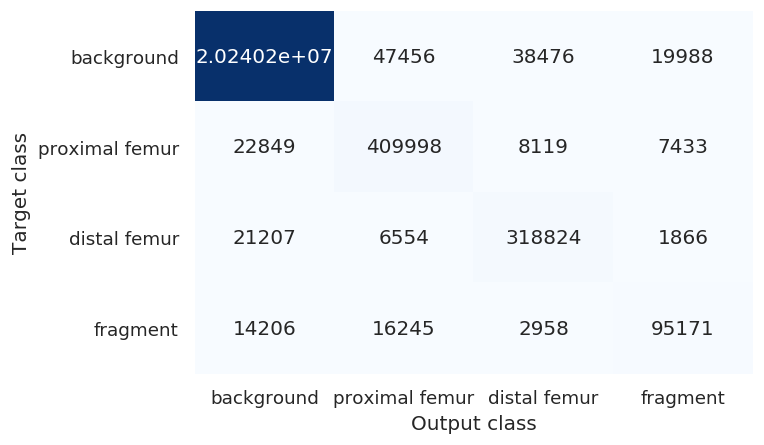

In [89]:
yt = np.array(yt)
yp = np.array(yp)
plt.figure(dpi=120)
sns.set()
cm = confusion_matrix(yt, yp)
xtick=['background','proximal femur','distal femur','fragment']
ytick=['background','proximal femur','distal femur','fragment']
sns.heatmap(cm,fmt='g',cmap='Blues',annot=True,cbar=False,xticklabels=xtick, yticklabels=ytick)
plt.ylabel('Target class')
plt.xlabel('Output class')
plt.show()

In [90]:
p = precision_score(yt, yp,average=None)
f1score = f1_score(yt, yp, average=None)
recall = recall_score(yt, yp, average=None)
print(p)
print(f1score)
print(recall)

[0.99712973 0.85371252 0.86548292 0.76468367]
[0.99596054 0.882996   0.88954115 0.75222694]
[0.99479409 0.91435976 0.91497513 0.74016954]
